# This is the main notebook for training and testing the proposed model and its variations

In [ ]:
# Wipe conflicting installs
!pip uninstall -y torch torchvision torchaudio monai timm

# Install the versions Colab already supports best (CUDA 12.1 build)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Then add MONAI + timm on top
!pip install monai timm

In [ ]:
# The full path to the project folder
project_folder = "/content/drive/MyDrive/ScarSegNet"

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import random
import torch
import timm
import json
import time
import sys
import os


# Mounting the google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
sys.path.append(project_folder)


from Config import ModelType
from Scar_Model.Model import Scar_Net
from Utils import visualize_scar_samples, load_data, train_validate, test, visualize_predictions_baseline


Mounted at /content/drive


# Prepare the training, validation and test data

In [ ]:

train_loader, val_loader, test_loader = load_data(f"{project_folder}/NUH/preprocessed")


100%|██████████| 3647/3647 [02:38<00:00, 23.02it/s]
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Visualise some samples from the test set

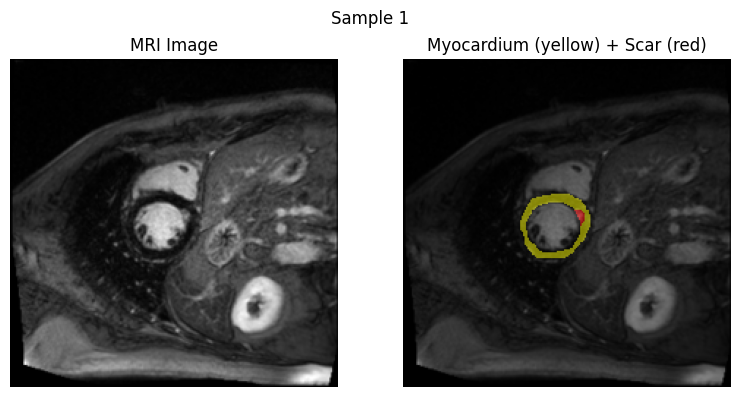

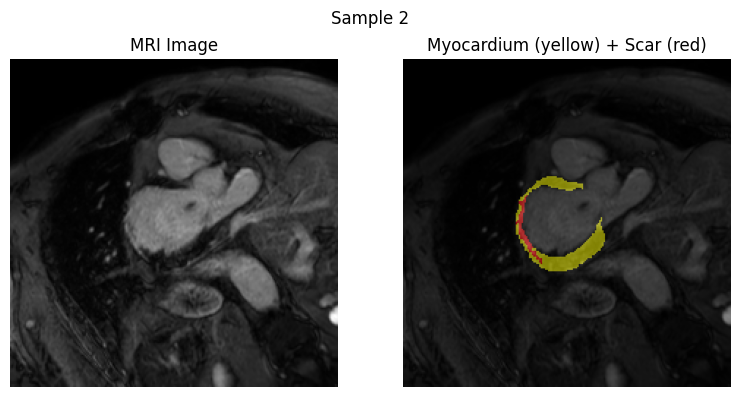

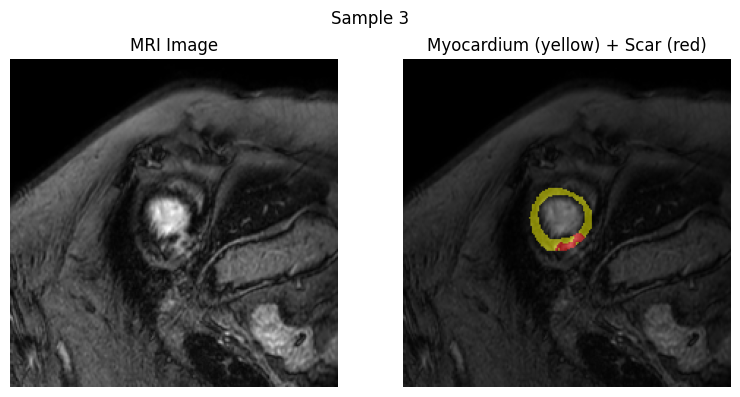

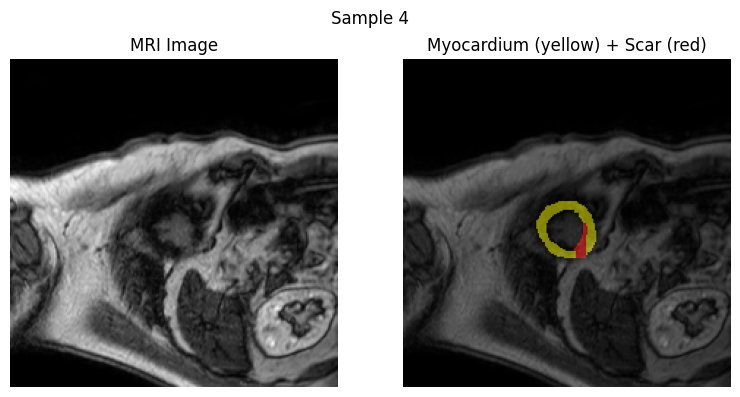

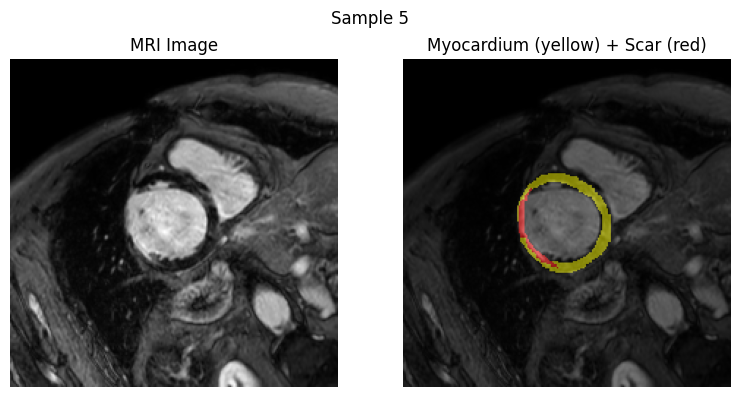

In [ ]:
visualize_scar_samples(test_loader, n=5)

# Model Training

In [ ]:
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
chkpt_folder = f"{project_folder}/Pth_files"


### !!! Uncomment the code below to retrain the models !!!

In [ ]:

# for model_type in ModelType:

#   print(f"******** Training {model_type.value} model ********")

#   model = Scar_Net(model_type, num_classes=1).to(device)

#   optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=5e-5, betas=(0.9, 0.99))
#   scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6)

#   checkpoint = train_validate(model, train_loader, val_loader, device, epochs, optimizer, scheduler, chkpt_folder, seed=0)

#   # Testing
#   model.load_state_dict(torch.load(checkpoint, map_location=device))

#   avg_test_dice = test(model, test_loader, device)

#   print(f"Model type: {model_type.value}")
#   print(f"Test Dice: {avg_test_dice:.3f}")

# Testing the models

In [ ]:

# Path to your JSON file
json_path = f"{project_folder}/patient_indices.json"

# Load it directly as a Python dict
with open(json_path, "r") as f:
    patient_slices = json.load(f)


for model_type in ModelType:
  model = Scar_Net(model_type, num_classes=1).to(device)
  model.load_state_dict(torch.load(os.path.join(chkpt_folder, f"{model_type.value}_model.pth"), map_location=device))

  test_results = test(model, test_loader, device, patient_slices)

  print(f"Model type: {model_type.value}")
  print(f"Test Results: {test_results}")

  # visualize_predictions_baseline(model, test_loader, device, f"{project_folder}/{model_type.value}_Predictions")


# Suitability for Prognosis

In [ ]:
import torch
import json
import os
import numpy as np
from tqdm import tqdm

def compute_patient_scar_percentage(model, test_loader, patient_index_file, device):
    """
    Compute ground-truth and predicted scar % LV per patient using test_loader batches.
    """
    # Load patient index dict
    with open(patient_index_file, "r") as f:
        patient_indices = json.load(f)

    # Reverse-map: slice_idx -> patient_id
    slice_to_patient = {}
    for patient_id, (start_idx, end_idx) in patient_indices.items():
        for i in range(start_idx, end_idx + 1):
            slice_to_patient[i] = patient_id

    model.eval()
    patient_results = {}

    # Init accumulators
    for pid in patient_indices.keys():
        patient_results[pid] = {"gt_scar": 0, "lv": 0, "pred_scar": 0}

    slice_idx = 0
    with torch.no_grad():
        for imgs, scar_masks, lv_masks in tqdm(test_loader, desc="Processing test set"):
            imgs = imgs.to(device).float()  # already [B, C, H, W]
            scar_masks = scar_masks.to(device).float().permute(0, 3, 1, 2)  # [B,1,H,W]
            lv_masks = lv_masks.to(device).float().permute(0, 3, 1, 2)      # [B,1,H,W]

            preds, _ = model(imgs)
            preds = torch.sigmoid(preds) > 0.5  # binarize prediction

            B = imgs.size(0)
            for b in range(B):
                pid = slice_to_patient[slice_idx]

                # Accumulate pixels
                patient_results[pid]["gt_scar"]   += scar_masks[b].sum().item()
                patient_results[pid]["lv"]        += lv_masks[b].sum().item()
                patient_results[pid]["pred_scar"] += preds[b].sum().item()

                slice_idx += 1

    # Final percentages
    results_pct = {}
    for pid, stats in patient_results.items():
        if stats["lv"] > 0:
            gt_pct   = (stats["gt_scar"] / stats["lv"]) * 100
            pred_pct = (stats["pred_scar"] / stats["lv"]) * 100
        else:
            gt_pct, pred_pct = 0.0, 0.0
        results_pct[pid] = {"gt_pct": gt_pct, "pred_pct": pred_pct}

    return results_pct



model = Scar_Net(ModelType.SCAR, num_classes=1).to(device)
model.load_state_dict(torch.load(os.path.join(chkpt_folder, f"{ModelType.SCAR.value}_model.pth"), map_location=device))

patient_scar_pct = compute_patient_scar_percentage(
    model, test_loader, f"{project_folder}/patient_indices.json", device
)

for pid, result in patient_scar_pct.items():
    print(f"{pid} | GT: {result['gt_pct']:.2f}% | Pred: {result['pred_pct']:.2f}%")



/tmp/ipython-input-45225914.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(chkpt_folder, f"{ModelType.SCAR.value}_model.p

20CA015_N001 | GT: 2.22% | Pred: 2.10%
20CA015_N007 | GT: 0.55% | Pred: 0.96%
20CA015_N017 | GT: 0.75% | Pred: 0.79%
20CA015_N024 | GT: 41.19% | Pred: 47.99%
20CA015_N027 | GT: 15.40% | Pred: 16.71%
20CA015_N033 | GT: 16.02% | Pred: 8.83%
20CA015_N034 | GT: 12.42% | Pred: 9.52%
20CA015_N036 | GT: 4.73% | Pred: 4.15%
20CA015_N045 | GT: 11.36% | Pred: 14.80%
20CA015_N058 | GT: 0.75% | Pred: 0.00%
20CA015_N076 | GT: 2.82% | Pred: 1.21%
20CA015_N080 | GT: 10.16% | Pred: 4.74%
20CA015_N081 | GT: 29.09% | Pred: 13.44%
20CA015_N107 | GT: 4.72% | Pred: 2.42%
20CA015_N116 | GT: 4.07% | Pred: 5.05%
20CA015_N117 | GT: 49.56% | Pred: 30.65%
20CA015_N127 | GT: 7.57% | Pred: 7.08%
20CA015_N136 | GT: 10.96% | Pred: 8.68%
20CA015_N145 | GT: 31.83% | Pred: 10.01%
20CA015_N153 | GT: 3.04% | Pred: 4.83%
20CA015_N157 | GT: 1.55% | Pred: 0.89%
20CA015_N163 | GT: 12.92% | Pred: 15.17%
20CA015_N178 | GT: 17.87% | Pred: 12.99%
20CA015_N182 | GT: 37.39% | Pred: 31.72%
20CA015_N217 | GT: 19.44% | Pred: 13.84%
2

In [ ]:

# Checking high-risk GT missed by predictions
missed_high_risk = []
for pid, res in patient_scar_pct.items():
    if res["gt_pct"] > 5 and res["pred_pct"] <= 5:
        missed_high_risk.append(pid)

print("Patients with GT > 5% but Pred ≤ 5%:")
print(missed_high_risk if missed_high_risk else "None missed")


Patients with GT > 5% but Pred ≤ 5%:
['20CA015_N080']


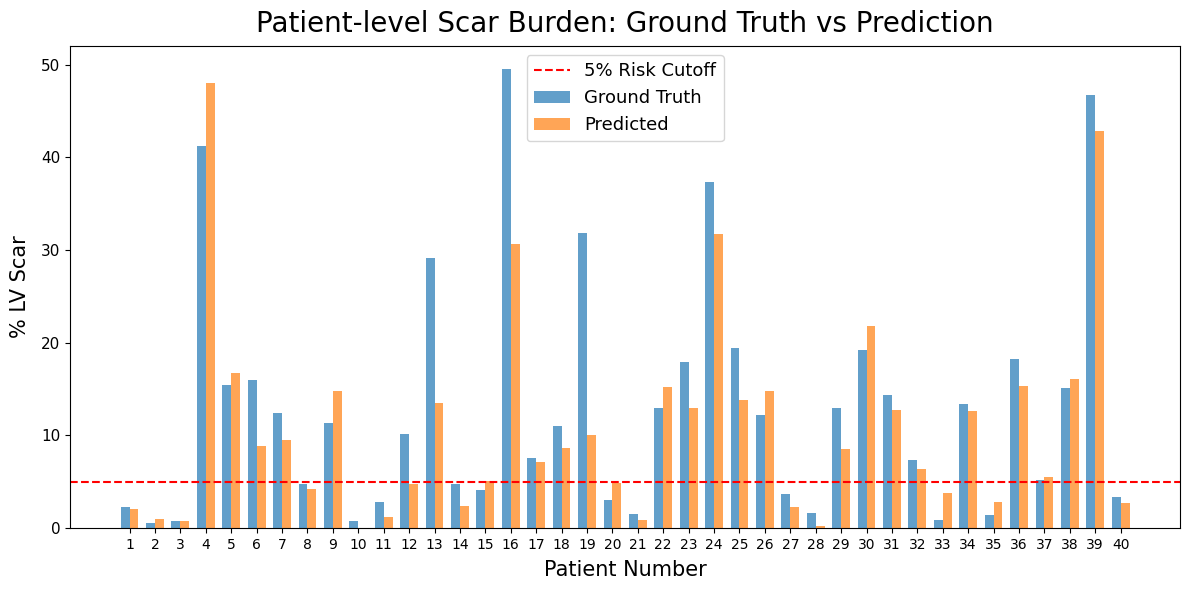

In [ ]:
import matplotlib.pyplot as plt

pids = list(patient_scar_pct.keys())
gt_vals = [res["gt_pct"] for res in patient_scar_pct.values()]
pred_vals = [res["pred_pct"] for res in patient_scar_pct.values()]

# Replace patient IDs with sequential numbers
x_labels = np.arange(1, len(pids) + 1)

x = np.arange(len(pids))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, gt_vals, width, label="Ground Truth", alpha=0.7)
plt.bar(x + width/2, pred_vals, width, label="Predicted", alpha=0.7)
plt.axhline(5, color="red", linestyle="--", linewidth=1.5, label="5% Risk Cutoff")

# Increase font sizes
plt.xticks(x, x_labels, rotation=0, fontsize=10)   # use numeric labels instead of patient IDs
plt.yticks(fontsize=11)
plt.ylabel("% LV Scar", fontsize=15, labelpad=8)
plt.xlabel("Patient Number", fontsize=15, labelpad=6)
plt.title("Patient-level Scar Burden: Ground Truth vs Prediction", fontsize=20, pad=10)
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import pearsonr, spearmanr

# Extract values
gt = [res["gt_pct"] for res in patient_scar_pct.values()]
pred = [res["pred_pct"] for res in patient_scar_pct.values()]

# Pearson
pearson_r, pearson_p = pearsonr(gt, pred)

# Spearman
spearman_r, spearman_p = spearmanr(gt, pred)

# MAE
mae = np.mean(np.abs(np.array(gt) - np.array(pred)))

print(f"Pearson r = {pearson_r:.3f} (p={pearson_p:.3e})")
print(f"Spearman r = {spearman_r:.3f} (p={spearman_p:.3e})")
print(f"MAE = {mae:.2f}% LV scar")



Pearson r = 0.901 (p=2.179e-15)
Spearman r = 0.914 (p=1.716e-16)
MAE = 3.56% LV scar
